#### Note for algorithms section: 
1. All algorithm notebooks are directly taken the from qiskit-textbook (https://qiskit.org/textbook/ch-states/introduction.html).
2. Slight changes are made to the codes to accomodate for the densitymatrix simulator backend.

# Superdense Coding

This notebook demonstrates the Superdense Coding (SDC) protocol. We first use Qiskit's simulator to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Superdense Coding and Quantum Teleportation](#difference)
2. [The Process](#process)    
    2.1 [Step 1](#step1)    
    2.2 [Step 2](#step2)    
    2.3 [Step 3](#step3)
3. [Simulating the Superdense Coding Protocol](#simulating)    
    3.1 [3.1 Visualizing Our Measurements](#visualising)    
4. [Superdense Coding on a Real Quantum Computer](#real_qc)


## 1. The Difference between Superdense Coding and Quantum Teleportation <a id='difference'></a>

Quantum teleportation and superdense coding are closely related, to avoid confusion we need to clarify the difference.

Quantum teleportation is a process by which the state of qubit ($|\psi\rangle$) can be transmitted from one location to another, using two bits of classical communication and a Bell pair. In other words, we can say it is a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of shared entanglement. Superdense coding is a procedure that allows someone to send two classical bits to another party using just a single qubit of communication.

| Teleportation                                     | Superdense Coding                                    |
|:-------------------------------------------------:|:----------------------------------------------------:|
| Transmit one<br>qubit using two<br>classical bits | Transmit two<br>classical bits<br>using one<br>qubit |


The teleportation protocol can be thought of as a flipped version of the superdense coding protocol, in the sense that Alice and Bob merely “swap their equipment.”



## 2. The Process <a id='process'></a>

![image1](images/superdense.jpg)

### 2.1 Step 1 <a id='step1'></a>
The process starts with a third party, who we'll call Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $|0\rangle$. He applies Hadamard gate ($H$) to the first qubit to create superposition. He then applies CNOT gate ($CX$) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mentioned earlier. 

#### Outcome States

We start in the state:

$$|00\rangle = |0\rangle_A\otimes |0\rangle_B$$

where the qubit to be sent to Alice is labeled with $A$ and the qubit to be sent to Bob is labeled $B$. Charlie first applies a Hadamard gate to the first qubit, which creates superposition and we get the state:


$$|+0\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$$



Then Charlie applies the CNOT gate. The CNOT gate entangles both qubits, i.e. it flips the target if the control is $|1\rangle$. Note that the control qubit is our rightmost qubit.



$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$



### 2.2 Step 2 <a id='step2'></a>

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send:


#### Encoding Rules for Superdense Coding (Alice protocol):
<table>
    <tr>
        <th>Intended Message</th>
        <th>Applied Gate</th>
        <th>Resulting State ($\cdot\tfrac{1}{\sqrt{2}}$)</th>
    </tr>
    <tr>
        <td>00</td>
        <td>$I$</td>
        <td>$|00\rangle + |11\rangle$</td>
    </tr>
    <tr>
        <td>01</td>
        <td>$X$</td>
        <td>$|10\rangle + |01\rangle$</td>
    </tr>
    <tr>
        <td>10</td>
        <td>$Z$</td>
        <td>$|00\rangle - |11\rangle$</td>
    </tr>
    <tr>
        <td>11</td>
        <td>$ZX$</td>
        <td>$-|10\rangle + |01\rangle$</td>
    </tr>
</table>

Thus if she wants to send a `00`, she does nothing to her qubit (apply the identity ($I$) gate). If she wants to send a `01`, then she applies the $X$ gate. Depending on what she wants to send, she applies the appropriate gate, then sends her qubit to Bob for the final step in the process.


### 2.3 Step 3 <a id='step3'></a>

Bob receives Alice's qubit (leftmost qubit) and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state in order to decode it — he simply uses the restoration operation.

Bob applies a CNOT gate using the leftmost qubit as control and the rightmost as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.

<table>
    <tr>
        <th>Bob Receives ($\cdot\tfrac{1}{\sqrt{2}}$)</th>
        <th>After CNOT-gate ($\cdot\tfrac{1}{\sqrt{2}}$)</th>
        <th>After H-gate</th>
    </tr>
    <tr>
        <td>$|00\rangle + |11\rangle$</td>
        <td>$|00\rangle + |10\rangle$</td>
        <td>$|00\rangle$</td>
    </tr>
    <tr>
        <td>$|10\rangle + |01\rangle$</td>
        <td>$|11\rangle + |01\rangle$</td>
        <td>$|01\rangle$</td>
    </tr>
    <tr>
        <td>$|00\rangle - |11\rangle$</td>
        <td>$|00\rangle - |10\rangle$</td>
        <td>$|10\rangle$</td>
    </tr>
    <tr>
        <td>$-|10\rangle + |01\rangle$</td>
        <td>$-|11\rangle + |01\rangle$</td>
        <td>$|11\rangle$</td>
    </tr>
</table>

## 3. Simulating the Superdense Coding Protocol <a id='simulating'></a>

In [10]:
# Importing everything
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

We saw that to create an entangled pair, we needed to do a H-gate followed by a CNOT. Let's create a function that takes a `QuantumCircuit` and entangles the qubits with indices `a` and `b`:

In [11]:
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

Next we need to encode our message. We saw that there were four possible messages we could send: `00`, `10`, `01` or `11`. Let's create a function that takes this message and applies the appropriate gates for us:

In [12]:
def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

Finally, we need to decode our message, we saw we could do this using a CNOT followed by a H-gate. Let's create a function that does this for us too:

In [13]:
def decode_message(qc):
    qc.cx(0, 1)
    qc.h(0)
    return qc

Finally, we can put this together to complete our protocol.

In [14]:
# Charlie creates the entangled pair between Alice and Bob
qc = create_bell_pair()

# We'll add a barrier for visual separation
qc.barrier()

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 1. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = '10'
qc = encode_message(qc, 1, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
qc = decode_message(qc)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

┌───┐      ░       ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░───────░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░ ┌───┐ ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░─┤ Z ├─░─┤ X ├──────░──╫─┤M├
             └───┘ ░ └───┘ ░ └───┘      ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

### 3.1 Visualizing Our Measurements <a id='visualising'></a>

{'00': 0.0, '01': 0.0, '10': 1.0, '11': 0.0}


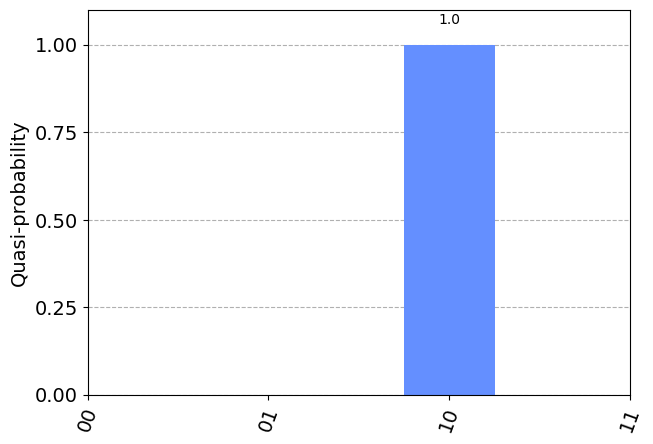

In [15]:
backend = Aer.get_backend('dm_simulator')
#run = execute(qc,backend,shots=1)
qc = transpile(qc,backend=backend)
run =  backend.run(qc)
result = run.result()

answer = result.results[0].data.partial_probability
print(answer)
#answer = result.get_probability()
plot_histogram(answer)

Our simulator simulates a perfect quantum computer. We can see that, without errors, we get a 100% chance of measuring the correct message.

In [17]:
import tutorial_magics

%qiskit_version_table